In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, hidden_size):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._get_positional_encoding(max_len, hidden_size)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    def _get_positional_encoding(self, max_len, hidden_size):
        positions = np.arange(max_len)[:, np.newaxis]
        indices = np.arange(hidden_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (indices // 2)) / np.float32(hidden_size))
        angle_rads = positions * angle_rates

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)


class TransformerLayer(layers.Layer):
    def __init__(self, hidden_size, num_heads):
        super(TransformerLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_size)
        self.dropout = layers.Dropout(0.1)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(hidden_size * 4, activation="relu"),
            layers.Dense(hidden_size)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def causal_attention_mask(self, batch_size, seq_len):
        # Mask out future positions (1 means keep, 0 means mask out)
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangular
        return tf.tile(mask[tf.newaxis, :, :], [batch_size, 1, 1])  # [batch_size, seq_len, seq_len]

    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len)

        attn_output = self.mha(x, x, attention_mask=causal_mask, training=training)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.norm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)



In [7]:
class AutoregressiveTransformer(tf.keras.Model):
    def __init__(self, vocab_size, max_len, hidden_size, num_layers, num_heads):
        super(AutoregressiveTransformer, self).__init__()

        self.embedding = layers.Embedding(vocab_size, hidden_size)
        self.pos_encoding = PositionalEncoding(max_len, hidden_size)
        self.transformer_layers = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.output_layer = layers.Dense(vocab_size)  # Predict token index

    def call(self, src, training=False):
        x = self.embedding(src)                      # Shape: [batch, seq_len, hidden]
        x = self.pos_encoding(x)                     # Add positional encoding

        for layer in self.transformer_layers:
            x = layer(x, training=training)

        return self.output_layer(x)                  # Shape: [batch, seq_len, vocab_size]


In [ ]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 1000
vocab_size = 100         # Max value in token + 1
max_len = 10             # Fixed length for padding
hidden_size = 64
num_heads = 4
num_layers = 2

# Model and optimizer
model = AutoregressiveTransformer(vocab_size, max_len, hidden_size, num_layers, num_heads)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Tracking loss
loss_history = []
epoch_history = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Choose sequence type
        use_fibonacci = False  # set True to use Fibonacci sequences instead of arithmetic

        n = random.randint(5, max_len)  # sequence length

        if use_fibonacci:
            start1 = random.randint(0, 5)
            start2 = random.randint(0, 5)
            training_data = [start1, start2]
            for i in range(2, n):
                training_data.append(training_data[i-1] + training_data[i-2])
        else:
            start = random.randint(0, vocab_size - 2 * n - 1)
            training_data = [start + 2 * i for i in range(n)]

        # Clip values to vocab size range
        training_data = [min(x, vocab_size - 1) for x in training_data]

        # Pad to max_len with 0s
        padded = training_data + [0] * (max_len - len(training_data))

        # Input/target split
        # example : src = padded[:-1] = [5, 7, 9, 11, 13, 0, 0]
        # then the target is: tgt = padded[1:] = [7, 9, 11, 13, 0, 0, 0] (shifted to the left)
        src = tf.constant([padded[:-1]], dtype=tf.int32)  # shape [1, max_len - 1]
        tgt = tf.constant([padded[1:]], dtype=tf.int32)   # shape [1, max_len - 1]

        # Forward + loss
        output = model(src, training=True)                # shape [1, max_len - 1, vocab_size]
        # THIS IS THE USUAL LOSS
        loss = loss_function(tgt, output)
        #print(tgt)
        #print(output)


    # Backward + update
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log
    loss_history.append(loss.numpy())
    epoch_history.append(epoch + 1)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")

# Plot training curve
plt.plot(epoch_history, loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


Epoch [10/1000], Loss: 5.3969
Epoch [20/1000], Loss: 4.4881
Epoch [30/1000], Loss: 3.0106
Epoch [40/1000], Loss: 4.7068
Epoch [50/1000], Loss: 3.4062
Epoch [60/1000], Loss: 4.9410
Epoch [70/1000], Loss: 2.8750
Epoch [80/1000], Loss: 3.8166
Epoch [90/1000], Loss: 1.9085
Epoch [100/1000], Loss: 4.4411
Epoch [110/1000], Loss: 4.9060
Epoch [120/1000], Loss: 4.8915
Epoch [130/1000], Loss: 2.8205
Epoch [140/1000], Loss: 2.9958
Epoch [150/1000], Loss: 5.0922
Epoch [160/1000], Loss: 3.4040
Epoch [170/1000], Loss: 2.9001
Epoch [180/1000], Loss: 5.4578
Epoch [190/1000], Loss: 4.3218
Epoch [200/1000], Loss: 3.9826
Epoch [210/1000], Loss: 2.7384
Epoch [220/1000], Loss: 4.4375
Epoch [230/1000], Loss: 3.5169
Epoch [240/1000], Loss: 3.7863
Epoch [250/1000], Loss: 4.9723
Epoch [260/1000], Loss: 2.1681
Epoch [270/1000], Loss: 4.2212
Epoch [280/1000], Loss: 4.2518
Epoch [290/1000], Loss: 2.8409
Epoch [300/1000], Loss: 3.7621
Epoch [310/1000], Loss: 4.1352
Epoch [320/1000], Loss: 2.9393
Epoch [330/1000],

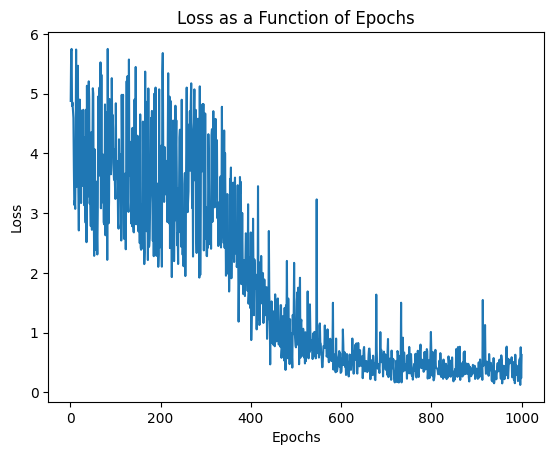

In [ ]:
# Plot the loss history
plt.plot(epoch_history, loss_history)
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
model.summary()

Model: "autoregressive_transformer_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (1, 9, 32)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_35          │ ?                      │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_68            │ ?                      │        25,280 │
│ (TransformerLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_69            │ ?                      │        25,280 │
│ (TransformerLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (1, 9, 100)            │         3,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,060 (222.89 KB)

 Trainable params: 57,060 (222.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Example test sequence: arithmetic pattern
test_data = [2,10,12]
# if input is [2, 10, 12, 14] output should be [10, 12, 14, 24, ...]
# or +2

# Pad the sequence to match model input size
padded = test_data + [0] * (max_len - len(test_data))
src = tf.constant([padded], dtype=tf.int32)  # shape [1, max_len]

# Get model predictions
model_output = model(src, training=False)  # shape [1, max_len, vocab_size]

# Get the predicted token (next-token prediction at each position)
predicted_token_ids = tf.argmax(model_output, axis=-1).numpy()  # shape [1, max_len]
predicted_token_ids = predicted_token_ids[0]  # remove batch dimension

# Print the prediction next to each input
print("Input sequence:        ", padded)
print("Next-token predictions:", predicted_token_ids)


NameError: name 'max_len' is not defined